In [23]:
%matplotlib inline
from scipy.stats import rv_continuous
from scipy.special import gamma
import numpy as np
from numpy import exp, sqrt
from scipy.integrate import quad
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
from sklearn.neighbors import KDTree
import sys
import lmfit
from py_unsio import *
import pymc
import os
from pymodelfit import FunctionModel1DAuto
import wkbl
import wkbl.astro.nbody_essentials as nbe
import cfalcon
import iminuit
import probfit
CF =cfalcon.CFalcon()

In [2]:
path = "/media/arturo/ARTUROTECA/OUTPUTS/HaloB/output_00417"
myhalo = wkbl.Galaxy_Hound(path,"halo,gas,stars",comov=True,getcen=False)

loading Dark matter..
is valid  True
loading Gas..
loading Stars..


In [3]:
print myhalo.st.pos3d[:,1].min(), myhalo.st.pos3d[:,1].max()
print myhalo.dm.pos3d[:,1].min(), myhalo.dm.pos3d[:,1].max()
print myhalo.gs.pos3d[:,1].min(), myhalo.gs.pos3d[:,1].max()

9529.66 10338.7
0.00878482 19914.6
77.7916 19836.9


In [4]:
po, ma = np.copy(myhalo.st.pos3d), np.copy(myhalo.st.mass)
centro_com = nbe.real_center(po,ma,n=7000)
print centro_com

[ 9684.81215375  9883.71475527  9818.63812203]


In [5]:
myhalo.st.pos3d = myhalo.st.pos3d - centro_com
myhalo.dm.pos3d = myhalo.dm.pos3d - centro_com
myhalo.gs.pos3d = myhalo.gs.pos3d - centro_com

myhalo.st.r = np.sqrt((myhalo.st.pos3d[:,0]**2)+(myhalo.st.pos3d[:,1]**2)+(myhalo.st.pos3d[:,2]**2))
myhalo.dm.r = np.sqrt((myhalo.dm.pos3d[:,0]**2)+(myhalo.dm.pos3d[:,1]**2)+(myhalo.dm.pos3d[:,2]**2))
myhalo.gs.r = np.sqrt((myhalo.gs.pos3d[:,0]**2)+(myhalo.gs.pos3d[:,1]**2)+(myhalo.gs.pos3d[:,2]**2))


In [6]:
myhalo.dm.mass = myhalo.dm.mass[np.where(myhalo.dm.r<300.)]
myhalo.dm.pos3d = myhalo.dm.pos3d[np.where(myhalo.dm.r<300.)]
myhalo.dm.vel3d = myhalo.dm.vel3d[np.where(myhalo.dm.r<300.)]
myhalo.dm.r = myhalo.dm.r[np.where(myhalo.dm.r<300)]

myhalo.st.mass = myhalo.st.mass[np.where(myhalo.st.r<300.)]
myhalo.st.pos3d = myhalo.st.pos3d[np.where(myhalo.st.r<300.)]
myhalo.st.r = myhalo.st.r[np.where(myhalo.st.r<300)]

myhalo.gs.mass = myhalo.gs.mass[np.where(myhalo.gs.r<300.)]
myhalo.gs.pos3d = myhalo.gs.pos3d[np.where(myhalo.gs.r<300.)]
myhalo.gs.r = myhalo.gs.r[np.where(myhalo.gs.r<300)]
myhalo.gs.rho = myhalo.gs.rho[np.where(myhalo.gs.r<300)]
myhalo.gs.hsml = myhalo.gs.hsml[np.where(myhalo.gs.r<300)]

In [7]:
average = np.array([np.mean(myhalo.dm.vel3d[:,0]),
                    np.mean(myhalo.dm.vel3d[:,1]),
                    np.mean(myhalo.dm.vel3d[:,2])
                   ])
print "average = ", average


myhalo.dm.vel3d = myhalo.dm.vel3d - average

average =  [-82.08541107  12.28345013 -15.60807896]


In [8]:
print "stars       x_min = {0}, x_max = {1} ".format(myhalo.st.pos3d[:,1].min(), myhalo.st.pos3d[:,1].max())
print "dark matter x_min = {0}, x_max = {1} ".format(myhalo.dm.pos3d[:,1].min(), myhalo.dm.pos3d[:,1].max())
print "gas         x_min = {0}, x_max = {1} ".format(myhalo.gs.pos3d[:,1].min(), myhalo.gs.pos3d[:,1].max())

stars       x_min = -223.392489646, x_max = 241.976650979 
dark matter x_min = -299.828036521, x_max = 299.135830667 
gas         x_min = -298.330966208, x_max = 299.692471292 


In [9]:
ok,rho_dm,_= CF.getDensity(np.array(myhalo.dm.pos3d.reshape(len(myhalo.dm.pos3d)*3),dtype=np.float32), myhalo.dm.mass)

In [10]:
ok,rho_st,_= CF.getDensity(np.array(myhalo.st.pos3d.reshape(len(myhalo.st.pos3d)*3),dtype=np.float32), myhalo.st.mass)

In [11]:
center_dens_st = myhalo.st.pos3d[np.where(rho_st == rho_st.max())]
print center_dens_st

[[-0.06020063 -1.06729433 -1.40862984]]


In [12]:
pos_dens_dm = myhalo.dm.pos3d - center_dens_st[0]
r_cd = np.sqrt((pos_dens_dm[:,0]**2)+(pos_dens_dm[:,1]**2)+(pos_dens_dm[:,2]**2))

In [13]:
R_hsml = myhalo.gs.hsml.min()
print R_hsml

0.151946


In [20]:
def gen_max(x, v0,alpha):
    n = v0**3 * gamma(1. + (3./(2.*alpha))) / 3.
    return (x**2/n) * np.exp(-(x/v0)**(2*alpha))

In [147]:
def vdf_per_center(center,title):
    #print center
    dm_pos3d = np.copy(myhalo.dm.pos3d) - center
    dm_r = np.sqrt((dm_pos3d[:,0]**2)+(dm_pos3d[:,1]**2)+(dm_pos3d[:,2]**2))
    #print "before ", len(myhalo.dm.vel3d)
    # define shell limits
    shell8kpc = (dm_r > 7.5) & (dm_r < 8.5)
    # velocity array
    vel3d_8kpc = myhalo.dm.vel3d[shell8kpc]
    tot = len(vel3d_8kpc)
    #print "after  ", tot
    #define array of mofdulus
    speed_8kpc = np.sqrt(vel3d_8kpc[:,0]**2 + vel3d_8kpc[:,1]**2 +vel3d_8kpc[:,2]**2)
    #print "min = {0}, max = {1}".format(speed_8kpc.min(),speed_8kpc.max())
    # make histogram
    bin_num = 50
    bins = np.linspace(0, 550,bin_num)
    w = 550 / bin_num 
    fdv = np.histogram(speed_8kpc,bins=bins,normed=1)
    # fit
    #extended_gen_max = probfit.Extended(gen_max)
    LH = probfit.BinnedLH(gen_max,speed_8kpc)
    minuit = iminuit.Minuit(LH, v0=250, limit_v0=(200,350),alpha=1.1,limit_alpha=(0.5,1.5), pedantic=False, print_level=0)
    minuit.migrad();
    #print minuit.values
    # plot
    fig, ax = plt.subplots(figsize=[5,5])
    ax.set_ylim([0,0.0046])
    ax.set_xlim([0,550])
    ax.set_title(title,fontsize=18)
    ax.bar(fdv[1][0:-1],fdv[0],width=w)
    ax.plot(bins,gen_max(bins,minuit.values['v0'],minuit.values['alpha']),'r', lw=2)
    ax.text(400,0.0035,
            r"$\alpha$ = {0:.3}".format(minuit.values['alpha']),
            fontsize=16,color='r'
           )
    ax.text(400,0.0030,
            r"$\sigma$ = {0:3}".format(int(minuit.values['v0'])),
            fontsize=16,color='r'
           )

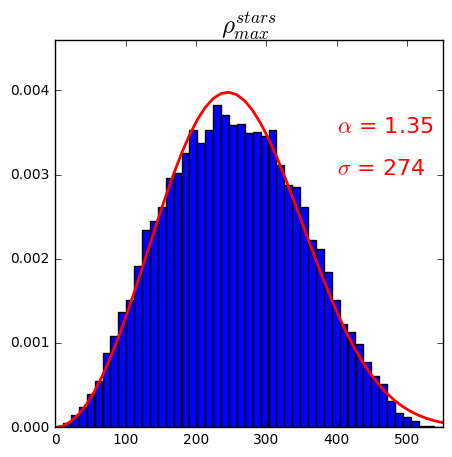

In [148]:
c_rho_st = myhalo.st.pos3d[np.where(rho_st==rho_st.max())]
vdf_per_center(c_rho_st, r"$\rho_{max}^{stars}$")

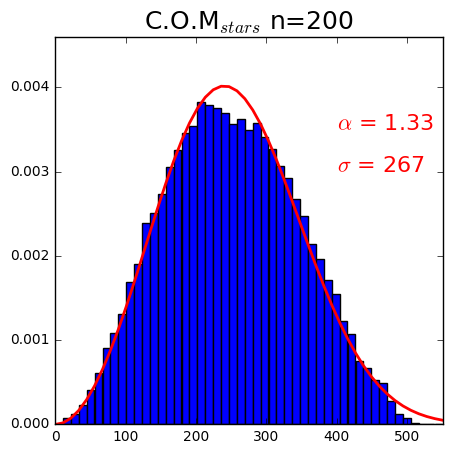

In [149]:
po, ma = np.copy(myhalo.st.pos3d), np.copy(myhalo.st.mass)
c_200 = nbe.real_center(po,ma,n=200)
vdf_per_center(c_200, r"C.O.M$_{stars}$ n=200")

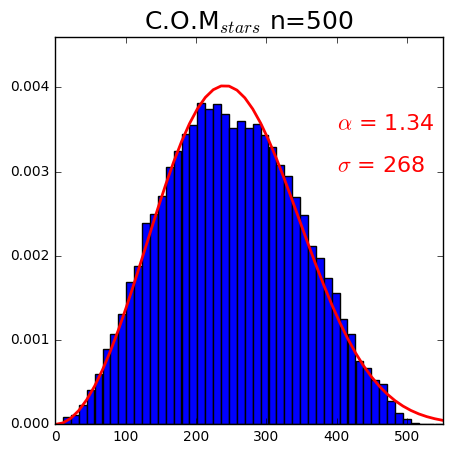

In [150]:
po, ma = np.copy(myhalo.st.pos3d), np.copy(myhalo.st.mass)
c_500 = nbe.real_center(po,ma,n=500)
vdf_per_center(c_500, r"C.O.M$_{stars}$ n=500")


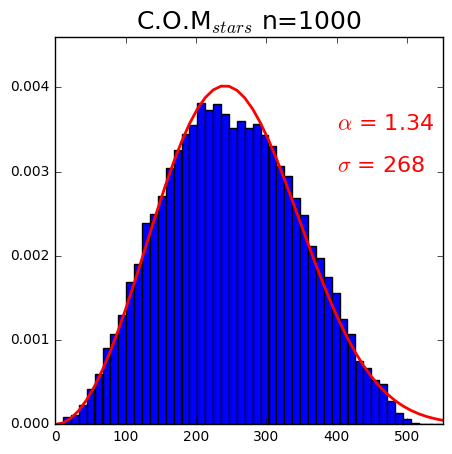

In [151]:
po, ma = np.copy(myhalo.st.pos3d), np.copy(myhalo.st.mass)
c_1000 = nbe.real_center(po,ma,n=1000)
vdf_per_center(c_1000, r"C.O.M$_{stars}$ n=1000")

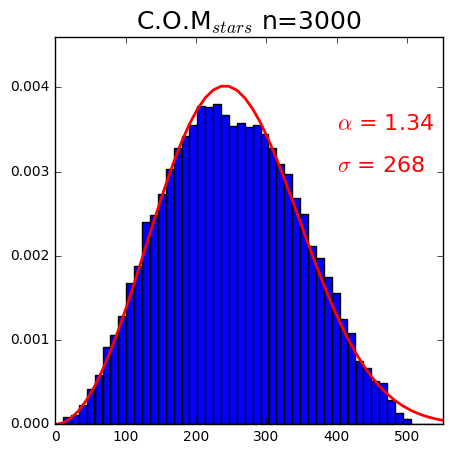

In [152]:
po, ma = np.copy(myhalo.st.pos3d), np.copy(myhalo.st.mass)
c_3000 = nbe.real_center(po,ma,n=3000)
vdf_per_center(c_3000, r"C.O.M$_{stars}$ n=3000")

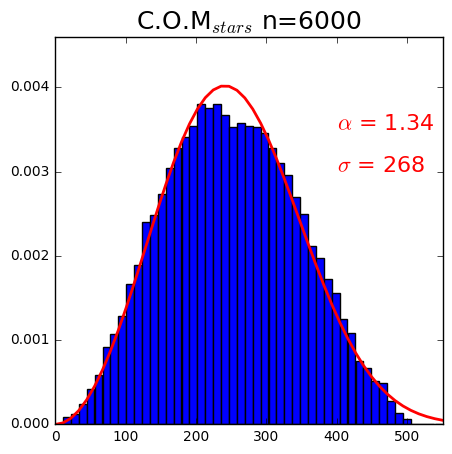

In [153]:
po, ma = np.copy(myhalo.st.pos3d), np.copy(myhalo.st.mass)
c_6000 = nbe.real_center(po,ma,n=6000)
vdf_per_center(c_6000, r"C.O.M$_{stars}$ n=6000")

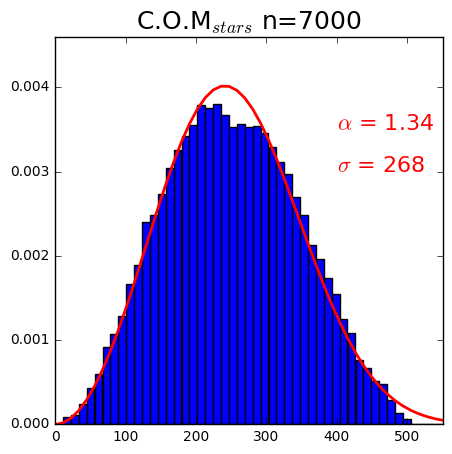

In [154]:
vdf_per_center([0,0,0],r"C.O.M$_{stars}$ n=7000")


# Dark matter

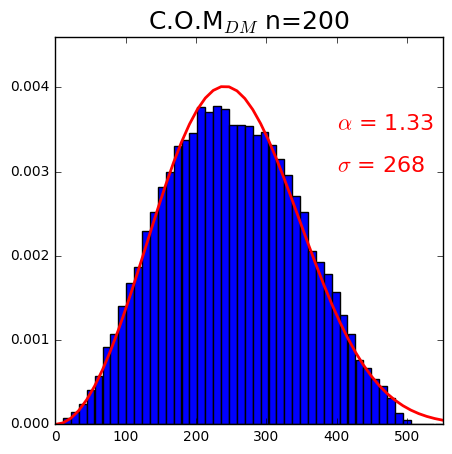

In [155]:
po, ma = np.copy(myhalo.dm.pos3d), np.copy(myhalo.dm.mass)
c_200 = nbe.real_center(po,ma,n=200)
vdf_per_center(c_200, r"C.O.M$_{DM}$ n=200")

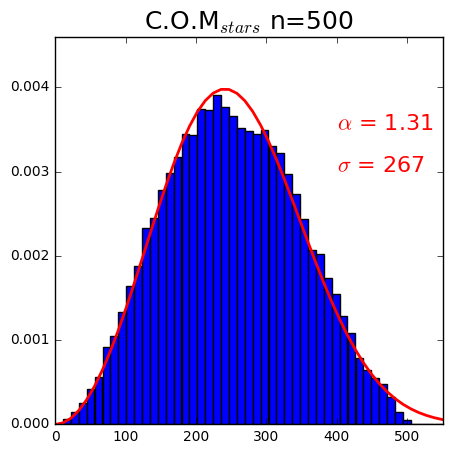

In [156]:
po, ma = np.copy(myhalo.dm.pos3d), np.copy(myhalo.dm.mass)
c_500 = nbe.real_center(po,ma,n=500)
vdf_per_center(c_500, r"C.O.M$_{stars}$ n=500")

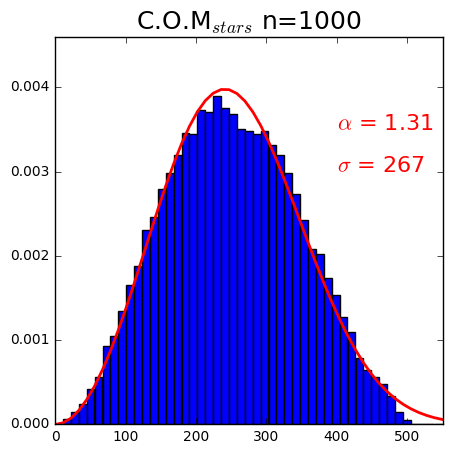

In [157]:
po, ma = np.copy(myhalo.dm.pos3d), np.copy(myhalo.dm.mass)
c_1000 = nbe.real_center(po,ma,n=1000)
vdf_per_center(c_1000, r"C.O.M$_{stars}$ n=1000")

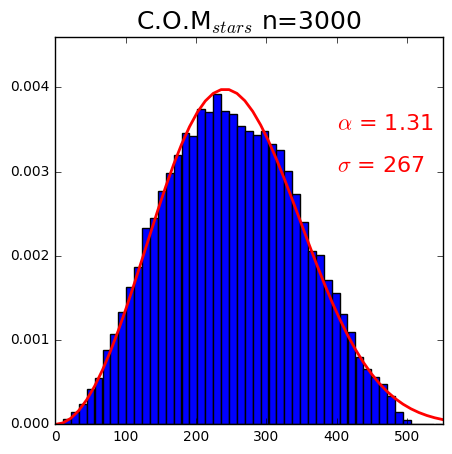

In [158]:
po, ma = np.copy(myhalo.dm.pos3d), np.copy(myhalo.dm.mass)
c_3000 = nbe.real_center(po,ma,n=3000)
vdf_per_center(c_3000, r"C.O.M$_{stars}$ n=3000")

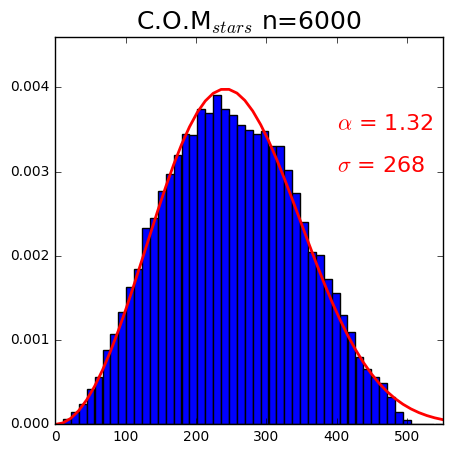

In [159]:
po, ma = np.copy(myhalo.dm.pos3d), np.copy(myhalo.dm.mass)
c_6000 = nbe.real_center(po,ma,n=6000)
vdf_per_center(c_6000, r"C.O.M$_{stars}$ n=6000")

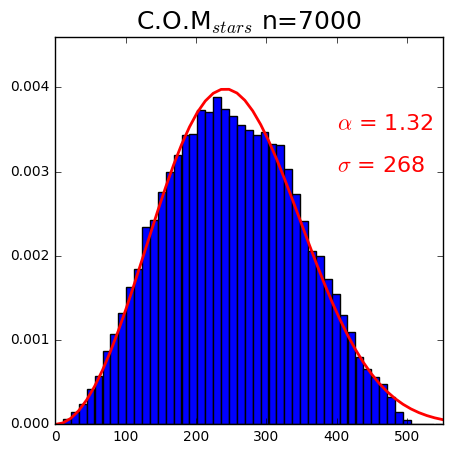

In [160]:
po, ma = np.copy(myhalo.dm.pos3d), np.copy(myhalo.dm.mass)
c_7000 = nbe.real_center(po,ma,n=7000)
vdf_per_center(c_7000, r"C.O.M$_{stars}$ n=7000")